### Prediction of Price of house using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

%matplotlib inline

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [150]:
# reading the dataset
housing = pd.read_csv("train.csv")

In [151]:
# summary of the dataset: 205 rows, 26 columns, no null values
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [152]:
percentages = round((housing.count() / len(housing)) * 100,2)
percentage_df = pd.DataFrame(percentages, columns=['Percentage'])
sorted_percentage_df = percentage_df.sort_values(by='Percentage', ascending=True)
sorted_percentage_df.head(20)

,Percentage
PoolQC,0.48
MiscFeature,3.70
Alley,6.23
Fence,19.25
FireplaceQu,52.74
LotFrontage,82.26
GarageYrBlt,94.45
GarageType,94.45
GarageFinish,94.45
GarageQual,94.45


Lets drop the following columns having less values.

In [153]:
col_drop=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage']
housing=housing.drop(col_drop,axis=1)

In [154]:
# head
housing.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Let's drop the rows with missing values

In [155]:
housing=housing.dropna()

In [156]:
housing.shape

(1338, 75)

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [157]:
# all numeric (float and int) variables in the dataset
housing_numeric = housing.select_dtypes(include=['float64', 'int64'])
housing_numeric.columns

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [158]:
housing['OverallQual'].astype('category').value_counts()

6     359
5     351
7     312
8     165
4      81
9      43
10     17
3       8
2       2
Name: OverallQual, dtype: int64

In [159]:
housing['OverallCond'].astype('category').value_counts()

5    770
6    233
7    183
8     68
4     46
9     20
3     15
2      3
Name: OverallCond, dtype: int64

'OverallQual' and 'OverallCond' are of categorical types so drop these column and also the ID column as it has no significance in model building

In [160]:
# dropping symboling and car_ID 
housing_numeric = housing_numeric.drop(['OverallQual','OverallCond','Id'], axis=1)
# Scale the values

housing_numeric.head()

,MSSubClass,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,8450,2003,2003,196.0,706,0,150,856,856,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,1976,1976,0.0,978,0,284,1262,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,2001,2002,162.0,486,0,434,920,920,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,1915,1970,0.0,216,0,540,756,961,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,2000,2000,350.0,655,0,490,1145,1145,...,192,84,0,0,0,0,0,12,2008,250000


This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [161]:
# correlation matrix
cor = housing_numeric.corr()
cor

,MSSubClass,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.134158,0.056456,0.038513,0.031333,-0.069053,-0.079329,-0.141025,-0.263613,-0.258787,...,-0.010175,-0.000359,-0.022598,-0.041391,-0.022748,0.010199,-0.021512,-0.016283,-0.021591,-0.079599
LotArea,-0.134158,1.000000,-0.005022,0.001681,0.096727,0.210148,0.110493,-0.014589,0.267188,0.288502,...,0.167822,0.084942,-0.017968,0.019326,0.038489,0.077050,0.040824,0.000118,-0.012066,0.254757
YearBuilt,0.056456,-0.005022,1.000000,0.617156,0.299410,0.224264,-0.070403,0.147762,0.385146,0.263585,...,0.212296,0.216793,-0.385415,0.028982,-0.070809,0.001006,-0.033493,0.004396,-0.007898,0.504297
YearRemodAdd,0.038513,0.001681,0.617156,1.000000,0.168311,0.099681,-0.085268,0.171881,0.264281,0.241889,...,0.201057,0.231129,-0.218452,0.039422,-0.052513,0.003354,-0.001379,0.014552,0.034503,0.501435
MasVnrArea,0.031333,0.096727,0.299410,0.168311,1.000000,0.253015,-0.083303,0.104662,0.365629,0.341001,...,0.149182,0.129015,-0.112225,0.015221,0.052474,0.009334,-0.028975,-0.013461,-0.001521,0.465811
BsmtFinSF1,-0.069053,0.210148,0.224264,0.099681,0.253015,1.000000,-0.064855,-0.552809,0.505000,0.450366,...,0.187178,0.107561,-0.105669,0.026811,0.051906,0.142708,0.007869,-0.021242,0.023958,0.359677
BsmtFinSF2,-0.079329,0.110493,-0.070403,-0.085268,-0.083303,-0.064855,1.000000,-0.233449,0.083184,0.094065,...,0.061206,0.004211,0.045668,-0.031475,0.085865,0.041148,0.006246,-0.022039,0.032855,-0.031226
BsmtUnfSF,-0.141025,-0.014589,0.147762,0.171881,0.104662,-0.552809,-0.233449,1.000000,0.363767,0.318097,...,-0.020711,0.122171,-0.003372,0.023701,-0.023065,-0.039315,-0.018566,0.031202,-0.039076,0.191689
TotalBsmtSF,-0.263613,0.267188,0.385146,0.264281,0.365629,0.505000,0.083184,0.363767,1.000000,0.893110,...,0.214364,0.255939,-0.104484,0.043142,0.068886,0.135654,-0.008679,0.000787,-0.001823,0.602042
1stFlrSF,-0.258787,0.288502,0.263585,0.241889,0.341001,0.450366,0.094065,0.318097,0.893110,1.000000,...,0.233200,0.226615,-0.056003,0.053159,0.083054,0.134879,-0.014226,0.024109,-0.011258,0.604714


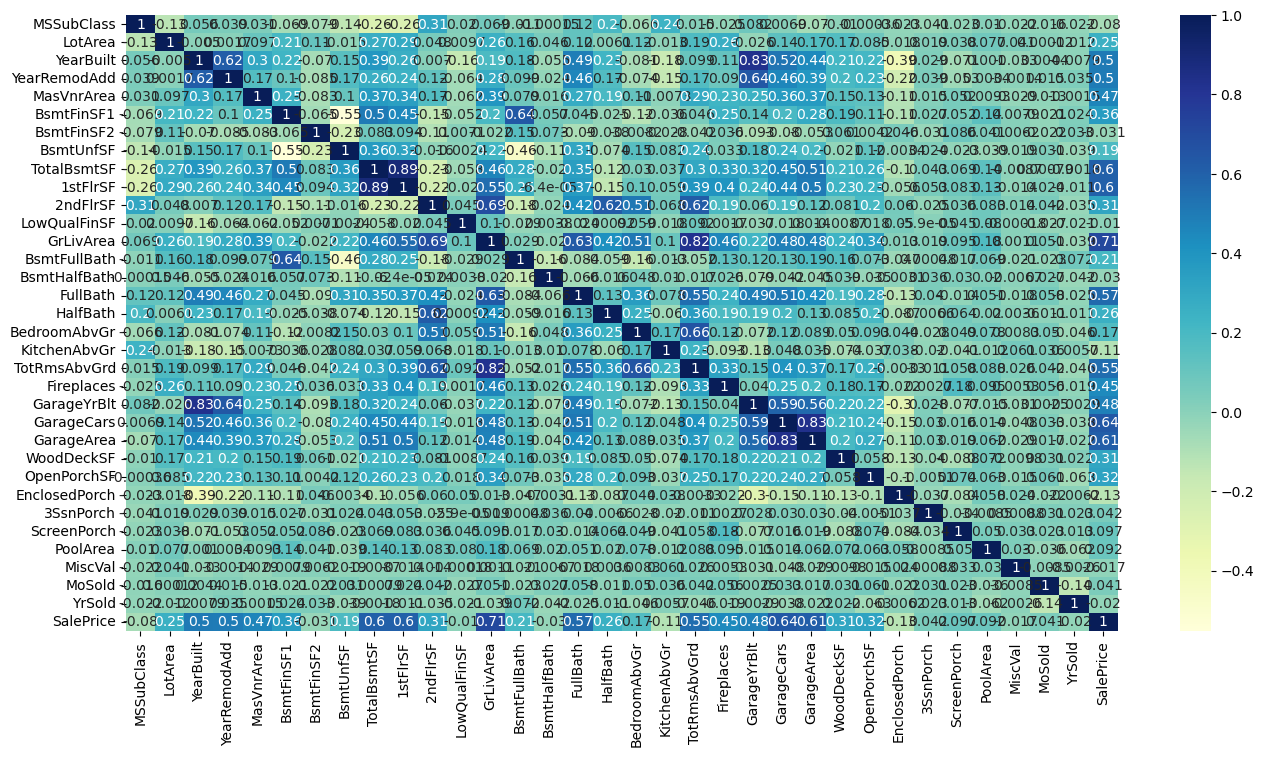

In [162]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of price with independent variables:
- Sale Price is highly (positively) correlated with GrLivArea, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, GarageCars, GarageArea

Correlation among independent variables:
- Many independent variables are highly correlated like GarageYrBlt is highly correlated with YearBuilt and YearRemodAdd, TotRmsAbvGrd is highly correlated with GrLivArea etc


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps. 

We have already dropped the columns ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage') at the begining with very less values 

We have also dropped the rows with missing values

We've also seen that variables are in the correct format, except ```OverallQual``` and ```OverallCond```, which should rather be a categorical variable (so that dummy variable are created for the categories).

Drop the 'Id' column as it has no significant impact on data modeling


In [163]:
housing=housing.drop('Id',axis=1)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1338 non-null   int64  
 1   MSZoning       1338 non-null   object 
 2   LotArea        1338 non-null   int64  
 3   Street         1338 non-null   object 
 4   LotShape       1338 non-null   object 
 5   LandContour    1338 non-null   object 
 6   Utilities      1338 non-null   object 
 7   LotConfig      1338 non-null   object 
 8   LandSlope      1338 non-null   object 
 9   Neighborhood   1338 non-null   object 
 10  Condition1     1338 non-null   object 
 11  Condition2     1338 non-null   object 
 12  BldgType       1338 non-null   object 
 13  HouseStyle     1338 non-null   object 
 14  OverallQual    1338 non-null   int64  
 15  OverallCond    1338 non-null   int64  
 16  YearBuilt      1338 non-null   int64  
 17  YearRemodAdd   1338 non-null   int64  
 18  RoofStyl

In [164]:
# converting symboling to categorical
housing[['OverallQual','OverallCond']] = housing[['OverallQual','OverallCond']].astype('object')
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1338 non-null   int64  
 1   MSZoning       1338 non-null   object 
 2   LotArea        1338 non-null   int64  
 3   Street         1338 non-null   object 
 4   LotShape       1338 non-null   object 
 5   LandContour    1338 non-null   object 
 6   Utilities      1338 non-null   object 
 7   LotConfig      1338 non-null   object 
 8   LandSlope      1338 non-null   object 
 9   Neighborhood   1338 non-null   object 
 10  Condition1     1338 non-null   object 
 11  Condition2     1338 non-null   object 
 12  BldgType       1338 non-null   object 
 13  HouseStyle     1338 non-null   object 
 14  OverallQual    1338 non-null   object 
 15  OverallCond    1338 non-null   object 
 16  YearBuilt      1338 non-null   int64  
 17  YearRemodAdd   1338 non-null   int64  
 18  RoofStyl

In [165]:
# outliers
housing.describe()

,MSSubClass,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,...,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,10706.294469,1973.029148,1985.668909,110.360239,464.234679,49.218236,582.494768,1095.947683,1176.221973,...,99.384903,47.782511,21.263827,3.585949,16.43423,3.010463,42.932735,6.331839,2007.805680,186761.782511
std,41.252576,10336.621126,29.563540,20.296463,185.604816,458.792420,166.196584,439.950528,405.554435,386.644986,...,127.537065,65.362562,60.843964,30.224622,58.05159,41.961337,508.056255,2.699437,1.330691,78913.847668
min,20.000000,1300.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,105.000000,438.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,7744.000000,1956.000000,1968.000000,0.000000,0.000000,0.000000,248.000000,819.750000,894.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,2007.000000,135000.000000
50%,50.000000,9600.000000,1976.000000,1994.500000,0.000000,413.000000,0.000000,489.000000,1021.500000,1098.000000,...,6.000000,28.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,2008.000000,168500.000000
75%,70.000000,11760.750000,2001.000000,2004.000000,174.000000,733.000000,0.000000,815.750000,1324.000000,1414.000000,...,174.500000,70.000000,0.000000,0.000000,0.00000,0.000000,0.000000,8.000000,2009.000000,220000.000000
max,190.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,857.000000,547.000000,552.000000,508.000000,480.00000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [166]:
# creating dummy variables for categorical variables

# subset all categorical variables
housing_categorical = housing.select_dtypes(include=['object'])
housing_categorical.head()


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [167]:
# convert into dummies - one hot encoding
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [168]:
# drop categorical variables 
housing= housing.drop(list(housing_categorical.columns), axis=1)

In [169]:
# concat dummy variables with X
housing = pd.concat([housing, housing_dummies], axis=1)

In [170]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [171]:
# Apply scaler() to all the numeric columns
num_vars = housing_numeric.columns

housing[num_vars] = scaler.fit_transform(housing[num_vars])

housing[num_vars].head()

,MSSubClass,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.033420,0.946154,0.883333,0.12250,0.125089,0.0,0.064212,0.125062,0.098260,...,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.240644
1,0.000000,0.038795,0.738462,0.433333,0.00000,0.173281,0.0,0.121575,0.192673,0.193700,...,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.203128
2,0.235294,0.046507,0.930769,0.866667,0.10125,0.086109,0.0,0.185788,0.135720,0.113305,...,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.261487
3,0.294118,0.038561,0.269231,0.333333,0.00000,0.038271,0.0,0.231164,0.108410,0.122943,...,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,0.145464
4,0.235294,0.060576,0.923077,0.833333,0.21875,0.116052,0.0,0.209760,0.173189,0.166197,...,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.298308


In [172]:
# split into X and y
y = housing.pop('SalePrice') # response variable in Y
X=housing


In [173]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [174]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [175]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

15146531366.109627
[-1.87390423e-02  1.40209296e-01  7.98921890e-02  4.90041326e-03
  3.20322448e-02 -1.39111004e+11 -3.63305493e+10 -5.75767728e+10
  1.48008784e+11 -6.17444835e+10 -2.99723457e+10 -8.30226718e+09
  7.55332140e+10 -7.62939453e-06  6.04152679e-04  5.75733185e-03
  4.06265259e-04 -3.55262756e-02 -2.60848999e-02  2.74658203e-02
  1.08127594e-02 -2.88298130e-02  1.95121765e-03  6.03160858e-02
  5.62596321e-03  1.67226791e-03  2.11234093e-02  2.26539373e-02
  1.47190094e-02  8.21185112e-02  5.56969643e-03 -2.90107727e-03
  9.05990601e-05  6.19430542e-02  5.79137802e-02  5.66978455e-02
  5.08136749e-02  2.31741667e-02  4.31585312e-03  1.03732347e-02
 -3.35693359e-04  1.18684769e-02 -1.50313377e-02  1.31349564e-02
 -5.69901466e-02  8.22448730e-03 -1.36694908e-02 -2.37083435e-03
 -3.87191772e-03  3.55815887e-03 -3.51572037e-02  1.40142441e-03
  4.81128693e-03  4.98771667e-03  4.12464142e-03 -4.30297852e-03
  2.59056091e-02 -2.32620239e-02 -3.16715240e-03 -5.12886047e-03
 -1.87

In [176]:
from sklearn.metrics import r2_score, mean_squared_error

In [177]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9352059730595267
-6.744576134794951e+20
0.7256918653842002
3.272624954848416e+21
0.0007753118219916669
8.140858096637851e+18


## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [178]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [179]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 3.0}


In [180]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 3
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.90828473e-02  2.19848476e-02  3.14204954e-02  9.71839117e-03
  3.56664526e-02  6.18360503e-02  5.57507268e-03 -9.58739826e-05
  5.94498523e-02  7.69697033e-02  8.12480763e-02  5.52976258e-03
  9.57666064e-02  1.71789844e-02  2.35716807e-03  3.34570463e-02
  9.26103932e-03 -2.60701034e-03 -2.31038271e-02  5.03350261e-02
  2.61820234e-02 -1.19322932e-02  1.92256353e-02  4.43275952e-02
  1.79246936e-02  5.55510258e-03  1.34115526e-02  1.58841041e-02
  1.57338253e-02  4.53390136e-02  3.84816712e-03 -4.99243000e-03
  3.24522312e-05  1.49224525e-02  7.53923338e-03  1.26102597e-02
  7.09377844e-03  1.28200349e-02  1.31938470e-02  1.46505862e-02
 -3.04551420e-03  1.55295232e-02 -3.67263337e-03  1.49962902e-02
 -1.03904951e-02  1.08208817e-02 -1.35973736e-02 -2.74066082e-03
 -4.02649968e-03  5.74261738e-03 -1.10682075e-02 -1.98751686e-03
 -3.17540910e-04  7.46086244e-03  3.29529596e-03 -4.88980111e-03
  2.46319667e-02 -2.17624602e-02 -1.09888218e-02 -1.18319783e-02
 -1.50721744e-02 -1.20945

In [181]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9172356369103497
0.7939441358307555
0.9269592873590409
0.9998309007058551
0.0009903411189733343
0.002487141544044416


## Lasso

In [182]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [183]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [184]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [185]:
lasso.coef_

array([-2.76281557e-02,  8.25642202e-04,  4.62493526e-02,  9.05721042e-03,
        2.85293557e-02,  1.16801889e-01,  2.60940961e-04, -0.00000000e+00,
        7.35419070e-02,  0.00000000e+00,  3.02757119e-02, -0.00000000e+00,
        3.59357363e-01,  1.02345496e-02, -0.00000000e+00,  1.02039620e-02,
       -0.00000000e+00, -0.00000000e+00, -2.81758242e-02,  1.19289873e-02,
        1.96949760e-02, -2.18957444e-03,  4.91644332e-03,  5.33610017e-02,
        6.25260481e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.33155985e-02,  4.93339194e-02, -0.00000000e+00, -2.49374059e-03,
        0.00000000e+00,  6.04494301e-03,  0.00000000e+00,  7.15435828e-03,
       -0.00000000e+00,  0.00000000e+00,  9.18025897e-03,  0.00000000e+00,
       -1.68446121e-03,  8.91799365e-03,  0.00000000e+00,  9.54337800e-03,
       -0.00000000e+00,  1.17509095e-02, -5.74394155e-03, -0.00000000e+00,
       -2.66815311e-03,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  

In [186]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9216919856046172
0.7606233064022259
0.8770482670158153
1.1615113024459847
0.0009370173792904009
0.0028893315981243397


In [187]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.352060e-01,0.917236,0.921692
1,R2 Score (Test),-6.744576e+20,0.793944,0.760623
2,RSS (Train),7.256919e-01,0.926959,0.877048
3,RSS (Test),3.272625e+21,0.999831,1.161511
4,MSE (Train),2.784442e-02,0.031470,0.030611
5,MSE (Test),2.853219e+09,0.049871,0.053753


## Lets observe the changes in the coefficients after regularization

In [188]:
betas = pd.DataFrame(index=X.columns)

In [189]:
betas.rows = X.columns

In [190]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [191]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
MSSubClass,-1.873904e-02,-0.019083,-0.027628
LotArea,1.402093e-01,0.021985,0.000826
YearBuilt,7.989219e-02,0.031420,0.046249
YearRemodAdd,4.900413e-03,0.009718,0.009057
MasVnrArea,3.203224e-02,0.035666,0.028529
BsmtFinSF1,-1.391110e+11,0.061836,0.116802
BsmtFinSF2,-3.633055e+10,0.005575,0.000261
BsmtUnfSF,-5.757677e+10,-0.000096,-0.000000
TotalBsmtSF,1.480088e+11,0.059450,0.073542
1stFlrSF,-6.174448e+10,0.076970,0.000000
